In [2]:
! pip install transformers

In [26]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  
import csv
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from transformers import  BertModel, BertTokenizer

In [46]:
from google.colab import drive
drive.mount('/content/drive')
folder = "./drive/My Drive/CSC2515/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_df = pd.read_csv("train.csv")

In [8]:
test_df = pd.read_csv("test.csv")

In [9]:
train_df.head()

,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4.0,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5.0,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5.0,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4.0,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN


In [10]:
test_df.head()

,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,"03 26, 2015",u32476110,"Fantastic mix of ""old school"" with a creative ...","Fantastic mix of ""old school"" with a creative ...",1427328000,Pop,$14.98,p76243483,20167847,NaN
1,"05 15, 2017",u36732410,Update: Indications\nThere are various opinion...,Digitally Extracted Stereo (DES) Rules!,1494806400,Pop,$15.16,p92485419,30527605,NaN
2,"06 4, 2015",u85385007,This album provides a new twist on old Sammy H...,Excellent unplugged album,1433376000,Pop,$7.37,p40031588,12169432,NaN
3,"04 23, 2009",u30715529,(Symbol) can be considered as another masterpi...,another masterpiece,1240444800,Pop,$12.45,p88719785,55648615,NaN
4,"09 15, 2000",u95909892,Many would think this album is good only becau...,True Classic Rock,968976000,Alternative Rock,$2.07,p59188380,9520938,NaN


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
maxLength = 200 #Max sequence length
printEvery = 100
outputFolder = 'Models'
outputFile = 'Part1_Model_1.1'
threads = 4
batchSize = 64
epochs = 3
lr = 5e-5

config = {"forceCPU" : False}
if config["forceCPU"]:
    device = torch.device("cpu")
config["device"] = device

In [14]:
num_ratings = train_df['overall'].nunique()

In [15]:
fraction_list = []
for i in range(num_ratings):
    fraction = train_df.overall.value_counts()[i+1]/len(train_df)
    fraction_list.append(fraction)
    print("rating:{}, fraction:{}".format(i+1, fraction_list[i]))

rating:1, fraction:0.03183
rating:2, fraction:0.03476
rating:3, fraction:0.0807
rating:4, fraction:0.19758
rating:5, fraction:0.65513


In [16]:
train_df.isnull().sum()

overall                0
reviewTime             0
reviewerID             0
reviewText            36
summary               37
unixReviewTime         0
category               0
price                  0
itemID                 0
reviewHash             0
image             199537
dtype: int64

In [17]:
test_df.isnull().sum()

reviewTime           0
reviewerID           0
reviewText           1
summary              3
unixReviewTime       0
category             0
price                0
itemID               0
reviewHash           0
image             9977
dtype: int64

In [18]:
train_df.reviewText.fillna("Ignore", inplace = True)
train_df.summary.fillna("Ignore", inplace = True)

In [19]:
test_df.reviewText.fillna("Ignore", inplace = True)
test_df.summary.fillna("Ignore", inplace = True)

In [20]:
train_df.isnull().sum()

overall                0
reviewTime             0
reviewerID             0
reviewText             0
summary                0
unixReviewTime         0
category               0
price                  0
itemID                 0
reviewHash             0
image             199537
dtype: int64

In [21]:
test_df.isnull().sum()

reviewTime           0
reviewerID           0
reviewText           0
summary              0
unixReviewTime       0
category             0
price                0
itemID               0
reviewHash           0
image             9977
dtype: int64

In [22]:
length_list = []
for review in train_df['reviewText']:
    length = len(review.split())
    length_list.append(length)

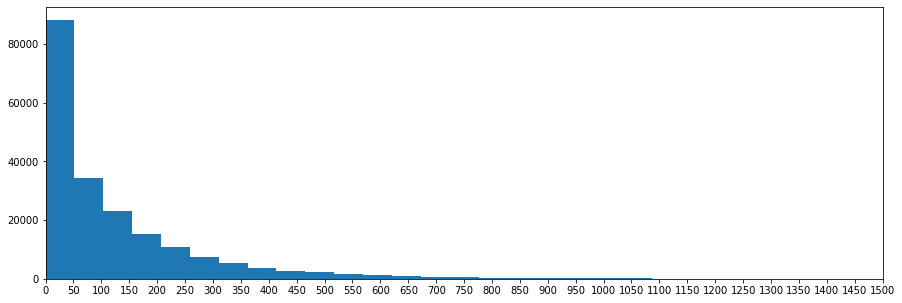

In [24]:
plt.figure(figsize = (15,5))
binsize = np.linspace(0, 1500, num=30)
plt.hist(length_list, bins = binsize)
plt.xlim(xmin=0, xmax = 1300)
plt.xticks(np.linspace(0, 1500, num=31))
plt.show()

In [27]:
class Train_Dataset(Dataset):
    def __init__(self, df, maxLength):
        self.df = df
        self.df.reset_index(drop=True, inplace=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.maxLength = maxLength

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        
        #can use tokenizer.encode("a visually stunning rumination on love", add_special_tokens=True) as well
        review = self.df.loc[index, 'reviewText']
        label = int(self.df.loc[index, 'overall'])
        # Use BERT tokenizer to match the tokens with the pre-trained tokens
        tokens = self.tokenizer.tokenize(review)
        # Insert [CLS] and [SEP] tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxLength:
            # Insert ['PAD'] token if the length is less than maxlength
            tokens = tokens + ['[PAD]' for item in range(self.maxLength-len(tokens))]
        else:
            # Truncate the tokens if length is greater than maxlength and add [SEP] token at the end
            tokens = tokens[:self.maxLength-1] + ['[SEP]']
        # Convert tokens to token ID
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        # Convert ID to tensors
        token_tensor = torch.tensor(token_ids)
        # Use attention mask, put 1 on the Non[PAD] tokens and 0 on the [PAD] tokens
        attn_mask = (token_tensor != 0).long()
        
        return token_tensor, attn_mask, label

In [28]:
class Test_Dataset(Dataset):
    def __init__(self, df, maxLength):
        self.df = df
        self.df.reset_index(drop=True, inplace=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.maxLength = maxLength

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        
        #can use tokenizer.encode("a visually stunning rumination on love", add_special_tokens=True) as well
        review = self.df.loc[index, 'reviewText']
        # Use BERT tokenizer to match the tokens with the pre-trained tokens
        tokens = self.tokenizer.tokenize(review)
        # Insert [CLS] and [SEP] tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxLength:
            # Insert ['PAD'] token if the length is less than maxlength
            tokens = tokens + ['[PAD]' for item in range(self.maxLength-len(tokens))]
        else:
            # Truncate the tokens if length is greater than maxlength and add [SEP] token at the end
            tokens = tokens[:self.maxLength-1] + ['[SEP]']
        # Convert tokens to token ID.
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        # Convert ID to tensors
        tokens_tensor = torch.tensor(token_ids)
        # Use attention mask, put 1 on the Non[PAD] tokens and 0 on the [PAD] tokens
        attn_mask = (tokens_tensor != 0).long()
        
        return tokens_tensor, attn_mask

In [29]:
train_set = Train_Dataset(train_df, maxLength)

In [30]:
test_set = Test_Dataset(test_df, maxLength)

In [33]:
train_loader = DataLoader(train_set, batch_size = batchSize, num_workers = threads)

In [34]:
test_loader = DataLoader(test_set, batch_size = 1, shuffle=False, num_workers = threads)

In [56]:
class Bert_Based(nn.Module):
    def __init__(self, device, freeze = True):
        super(Bert_Based, self).__init__()
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        self.device = device
        if freeze:
            for param in self.bert_layer.parameters():
                param.requires_grad = False
        self.linear = nn.Linear(768, 1)

    def forward(self, sequence, attn_masks):
        #Input sequence and attention mask into the Bert Model
        embeddings = self.bert_layer(sequence, attention_mask = attn_masks)[0]
        #print("$$$$",embeddings.size()) size: (64, 50, 768)
        #Get the [CLS] vector
        CLS = embeddings[:, 0, :]
        #Get the output
        output = self.linear(CLS)

        return output.to(self.device)

In [37]:
# Unbreeze the BERT layers to fine tune
model = Bert_Based(config["device"], freeze=False)
model.to(config["device"])

Bert_Based(
  (layers): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [40]:
#Use MSE loss and Adam optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

In [41]:
def train(model, loss_func, optimizer, train_loader):
    best_loss = 50
    for epoch in range(epochs):
        for it, (sequence, attn_masks, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            sequence, attn_masks, labels = sequence.to(device), attn_masks.to(device), labels.to(device)
            output = model(sequence, attn_masks).view(batchSize)
            loss = loss_func(output.float(), labels.float())
            loss.backward()
            optimizer.step()

            if (it + 1) % printEvery == 0: 
                print("Iteration: ", it+1) #printEvery = 100
                if not os.path.exists(outputFolder):
                    os.makedirs(outputFolder)

                #Save the model
                torch.save(net.state_dict(), os.path.join(folder, outputFolder, outputFile))                
                print("Iteration {} of epoch {} complete. Loss : {}".format(it+1, epoch+1, loss.item()))
                print("Saving at", os.path.join(folder, outputFolder, outputFile))

In [ ]:
torch.cuda.set_device(0)
train(model, loss_func, optimizer, train_loader)

Iteration:  100
Iteration 100 of epoch 1 complete. Loss : 0.6286003589630127
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  200
Iteration 200 of epoch 1 complete. Loss : 0.5087003707885742
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  300
Iteration 300 of epoch 1 complete. Loss : 0.4917103350162506
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  400
Iteration 400 of epoch 1 complete. Loss : 0.59682697057724
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  500
Iteration 500 of epoch 1 complete. Loss : 0.3235342502593994
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  600
Iteration 600 of epoch 1 complete. Loss : 0.25126588344573975
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  700
Iteration 700 of epoch 1 complete. Loss : 0.4150974750518799
Saving at ./drive/My Drive/CSC2515/Models/Part1_Model_1.1
Iteration:  800
Iteration 800 of epoch 1 complete. Loss 

In [57]:
#Test
model = Bert_Based(config["device"], freeze=False)

model.load_state_dict(torch.load(os.path.join(folder, outputFolder, outputFile), map_location=config["device"]))
print("Loaded model at ", os.path.join(outputFolder, outputFile))

Loaded model at  Models/Part1_Model_1.1


In [ ]:
with torch.no_grad():
    test_prediction = []
    for sequence, attn_masks in test_loader:
        prediction = model(sequence, attn_masks)
        test_prediction.append(prediction)

In [ ]:
overall_prediction = []
for i in test_prediction:
    i = i.cpu()
    pred = i.numpy()[0]
    pred = float(pred)
    overall_prediction.append(pred)

In [ ]:
overall_prediction = np.array(overall_prediction)

In [ ]:
overall_prediction[overall_prediction>5] = 5
overall_prediction[overall_prediction<1] = 1

overall_prediction

array([4.87720203, 4.97248363, 4.85904264, 4.97852707, 4.99567699,
       4.61894798, 4.67376328, 4.24351788, 4.98330307, 4.96363878,
       4.95370102, 5.        , 5.        , 4.97684813, 4.97836494,
       4.77745914, 4.90752125, 4.9836936 , 4.35811663, 4.97587013,
       4.92942524, 4.96898842, 1.38674247, 4.95816612, 5.        ,
       4.92871714, 4.67634535, 4.97379303, 1.75161278, 5.        ,
       4.90062141, 2.74343181, 4.94643641, 2.87148643, 4.98079205,
       4.66792154, 5.        , 4.51592779, 5.        , 4.80105305,
       3.28209996, 4.53129959, 4.95036459, 4.54533768, 4.70120525,
       4.90523672, 4.83356953, 4.59391165, 4.90145159, 4.13646507,
       4.65749216, 3.40151715, 3.54377866, 4.97765923, 5.        ,
       2.97373962, 4.98811817, 4.99264097, 4.90889835, 4.74279308,
       4.87894917, 2.83670378, 4.92847395, 4.86645126, 4.91652298,
       4.9663496 , 4.9708457 , 2.63088679, 4.84177303, 4.63620043,
       4.98881912, 4.89036465, 3.85187435, 5.        , 5.     

In [ ]:
prediction_df = pd.read_csv("rating_pairs.csv")

In [ ]:
prediction_df['prediction'] = overall_prediction

In [ ]:
prediction_df.tail()

,userID-itemID,prediction
9995,u75493520-p47578844,4.421404
9996,u85298918-p49438960,4.672206
9997,u73735798-p85068973,4.888999
9998,u67631525-p59188380,4.793400
9999,u45357230-p52824671,4.248274


In [ ]:
prediction_df.to_csv('predictions.csv')
!cp data.csv "drive/My Drive/"